## **<span style="color:lime">Fifth section</span>: *benchmark***
| *Cells* | *Content* |
|---|---|
| 5.1 *Setup* | Imports and helpers |
| 5.2 *Benchmark* | Encode/decode timing vs dataset size |

#### **<span style="color:purple">Notes</span>**
This notebook measures scaling of encode/decode operations on synthetic data.

# HashComb — Benchmark

In [6]:
from pathlib import Path
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make local package importable
root = Path.cwd()
repo_root = root
for _ in range(6):
    if (repo_root / "pyproject.toml").exists():
        break
    if repo_root.parent == repo_root:
        break
    repo_root = repo_root.parent

src_dir = repo_root / "src"
if src_dir.exists():
    sys.path.append(str(src_dir))

artifacts_dir = repo_root / "notebooks" / "artifacts"
artifacts_dir.mkdir(parents=True, exist_ok=True)

from hashcomb import Encoder, Decoder

### 5.2 *Benchmark*
We time `encodeArray` and `decodeArray` for increasing dataset sizes.

In [7]:
def run_benchmark(sizes, *, channels=6, vmin=0.0, vmax=10.0, trials=3):
    config_path = artifacts_dir / "bench_config.pkl"
    enc = Encoder(channels, vmax, vmin, configPath=str(config_path))
    dec = Decoder(configPath=str(config_path))

    rows = []
    rng = np.random.default_rng(123)

    for n in sizes:
        data = rng.uniform(vmin, vmax, size=int(n))

        # encode timing
        t_enc = []
        for _ in range(trials):
            t0 = time.perf_counter()
            tokens = enc.encodeArray(data)
            t_enc.append(time.perf_counter() - t0)

        # decode timing
        t_dec = []
        for _ in range(trials):
            t0 = time.perf_counter()
            _ = dec.decodeArray(tokens)
            t_dec.append(time.perf_counter() - t0)

        rows.append({
            "n": int(n),
            "encode_ms": 1000 * float(np.mean(t_enc)),
            "decode_ms": 1000 * float(np.mean(t_dec)),
            "encode_mpps": float(n) / (1e6 * float(np.mean(t_enc))),
            "decode_mpps": float(n) / (1e6 * float(np.mean(t_dec))),
        })

    df = pd.DataFrame(rows).sort_values("n").reset_index(drop=True)
    return df

sizes = [1_000, 5_000, 10_000, 50_000, 100_000, 250_000, 500_000, 1_000_000]
df = run_benchmark(sizes, trials=3)
df

,n,encode_ms,decode_ms,encode_mpps,decode_mpps
0,1000,18.282900,0.172167,0.054696,5.808326
1,5000,87.540067,0.858467,0.057117,5.824338
2,10000,172.875767,1.524033,0.057845,6.561536
3,50000,847.599400,7.646033,0.058990,6.539339
4,100000,1717.897267,28.536833,0.058211,3.504243
5,250000,4412.242733,43.189033,0.056661,5.788507
6,500000,8878.310367,85.486767,0.056317,5.848858
7,1000000,18224.337367,176.949467,0.054872,5.651331


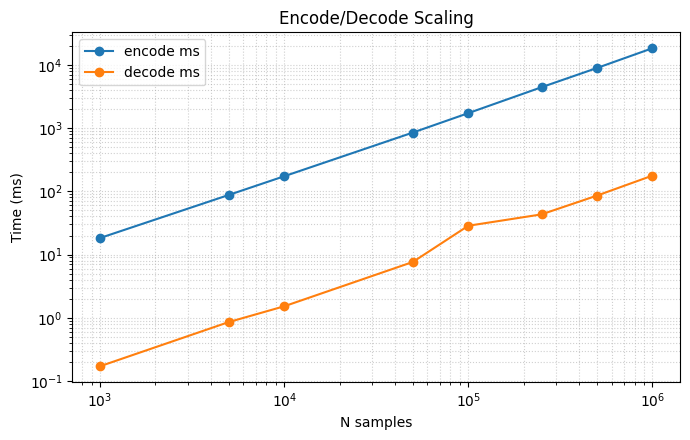

In [8]:
plt.figure(figsize=(7, 4.5))
plt.plot(df["n"], df["encode_ms"], marker="o", label="encode ms")
plt.plot(df["n"], df["decode_ms"], marker="o", label="decode ms")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("N samples")
plt.ylabel("Time (ms)")
plt.title("Encode/Decode Scaling")
plt.grid(True, which="both", linestyle=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()